In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Lambda, ToTensor, v2
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
class MNIST_Library:
    def __init__(self, random_state = 0):
        self.permuted_indices = np.arange(784)
        np.random.seed(random_state)
        np.random.shuffle(self.permuted_indices)
        self.reverse_indices = np.empty_like(self.permuted_indices)
        self.reverse_indices[self.permuted_indices] = np.arange(self.permuted_indices.size)
        self.transforms = v2.Compose([
            ToTensor(),
            Lambda(lambda x: torch.flatten(x)),
            Lambda(lambda x: x[self.permuted_indices]),
            #Lambda(lambda x: x[self.reverse_indices]), # Un permute
            #Lambda(lambda x: torch.unflatten(x, dim=0, sizes=[28, 28])) # Un flatten
        ])
        self.train_dataset = torchvision.datasets.MNIST('Data/train_mnist.pt', transform=self.transforms)
        self.test_dataset = torchvision.datasets.MNIST('Data/test_mnist.pt', transform=self.transforms, train = False)
    def get_train_dataloader(self, batch_size=64):
        return DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
    def get_test_dataloader(self, batch_size=64):
        return DataLoader(self.test_dataset, batch_size=batch_size, shuffle=True)

0:0.026035834103822708
1:0.026507355272769928
2:0.026446016505360603
3:0.02673887088894844
4:0.026111772283911705


/tmp/ipykernel_22901/821449728.py:129: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  rec_approx = (np.polynomial.legendre.Legendre(rec_coefs)(domain).T)


torch.Size([100, 1, 16])


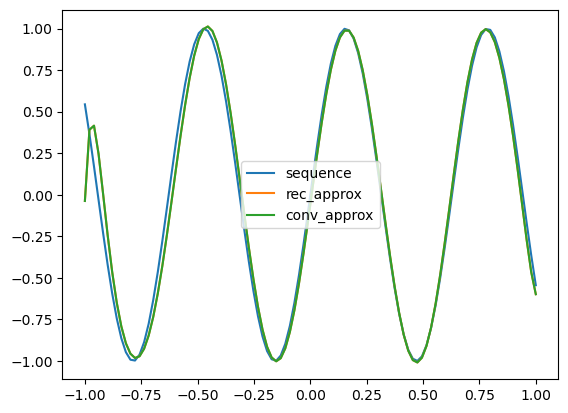

In [3]:
class S4Layer(nn.Module):
    def __init__(self, latent_size=8, in_channels = 1, out_channels=10, device=torch.device('cpu'), max_seq_length=1000):
        super().__init__()
        self.latent_size = latent_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.device = device

         # Use hippo matrices for A and B
        self.A = self.gen_A(self.latent_size)
        self.B = self.gen_B(self.latent_size)
        self.C = torch.rand(self.latent_size, self.out_channels).to(self.device).requires_grad_()
        self.D = torch.rand(self.in_channels, self.out_channels).to(self.device).requires_grad_()
        self.K = None
        self.A_stack = None
        self.B_stack = None
        self.log_softmax = nn.LogSoftmax(-1)

    def gen_A(self, N):
        A = torch.zeros(N, N)
        for n in range(N):
            for k in range(N):
                if n > k:
                    A[n, k] = -(2*n + 1)**.5 * (2*k + 1)**.5
                elif n == k:
                    A[n, k] = -(n+1)
        return A
        
    def gen_B(self, N):
        B = torch.zeros(N)
        for n in range(N):
            B[n] = (2*n+1)**.5
        return nn.Parameter(B.unsqueeze(1)).to(self.device)
        
    def discretize(self, step):
        A = self.A.to('cpu')
        B = self.B.to('cpu')
        N = A.shape[0]
        I = torch.eye(N)
        A_bar = torch.linalg.solve_triangular(I - (step / 2.0) * A, (I + (step / 2.0) * A), upper=False)
        B_bar = torch.linalg.solve_triangular((I - (step / 2.0) * A), B * step, upper=False)
        return A_bar.to(self.device), B_bar.to(self.device)
    
    def get_legendre_kernel(self, seq_length):
        if self.A_stack is None or self.B_stack is None:
            self.A_stack = torch.eye(self.latent_size).unsqueeze(-1).repeat((1, 1, seq_length)).permute(2, 0, 1).to(self.device)
            self.B_stack = torch.zeros(seq_length, self.latent_size, self.in_channels).to(self.device)
            for idx in range(0, seq_length):
                A_bar, B_bar = self.discretize(step=1.0/(idx + 1))
                self.A_stack[:idx] = self.A_stack[:idx] @ A_bar
                self.B_stack[idx] = B_bar
            self.A_stack = self.A_stack.permute(1, 2, 0)
            return self.A_stack, self.B_stack
        else:
            if seq_length > self.A_stack.shape[2]:
                print('recalcing kernel')
                self.A_stack = None
                self.B_stack = None
                return self.get_legendre_kernel(seq_length)
            else:
                return self.A_stack, self.B_stack
    def forward(self, u, conv=True):
        # u has shape [batch_size, in_channels, sequence_length]
        if len(u.shape) == 2:
            u = u.unsqueeze(1)
        elif len(u.shape) != 3:
            print('Unknown number of dimensions in forward_conv')
            assert False
        batch_size, in_channels, seq_length = u.shape
        if conv:
            output = self.get_legendre_conv(u)
        else:
            output = self.get_legendre_rec(u)
        output = output.detach()
        output =  output @ self.C + u.permute(2, 0, 1) @ self.D
        return self.log_softmax(output).permute(1, 2, 0)
    
    def get_legendre_rec(self, sequence):
        batch_size, in_channels, seq_length = sequence.shape
        x = torch.zeros([batch_size, self.latent_size, seq_length + 1]).to(self.device)
        for idx in range(seq_length):
            A_bar, B_bar = self.discretize(step=1.0/(1+idx))
            x[:, :, idx+1] = x[:,:, idx] @ A_bar.mT + sequence[:,:,idx] @ B_bar.mT
        # x has shape [batch_size, self.latent_size, seq_length + 1]
        output = x[:, :, 1:]
        # Output is of shape [batch_size, latent_size, seq_length]
        return (self.B * output).permute(2, 0, 1)
    def get_legendre_conv(self, sequence):
        # Sequence of shape [batch_size, in_channels, seq_length]
        batch_size, in_channels, seq_length = sequence.shape
        A_stack, B_stack = self.get_legendre_kernel(seq_length)
        # Apply B stack
        u = torch.bmm(sequence.permute(2, 0, 1), B_stack.mT).permute(1, 2, 0)
        # u has shape [batch_size, latent_size, seq_length]
        # Pad front with zeros to create correct convolutional form
        u_pad = F.pad(u, (seq_length-1, 0))
        # u_pad has shape [batch_size, latent_size, 2*seq_length-1]
        output = F.conv1d(u_pad, A_stack)
        # Output is of shape [batch_size, latent_size, seq_length]
        return (self.B * output).permute(2, 0, 1)
    
# TESTS
equivolence_test = True
if equivolence_test:
    torch.random.manual_seed(0)
    device = torch.device('cuda')
    model = S4Layer(latent_size = 4, in_channels=1, out_channels=10, device=device)
    library = MNIST_Library()
    dl = library.get_test_dataloader(2048)
    for idx, (u, y) in enumerate(dl):
        u = u.unsqueeze(1).to(device)
        y_pred_rec = model.forward(u, conv=False)
        y_pred_conv = model.forward(u, conv=True)
        print(f'{idx}:{torch.sum(y_pred_rec-y_pred_conv)/torch.prod(torch.tensor(y_pred_rec.shape))}')
legendre_test = True
if legendre_test:
    np.random.seed(0)
    N=16
    idx=99
    domain = torch.linspace(-1, 1, 100)
    sequence = torch.sin(10*domain).unsqueeze(0).unsqueeze(0) # Add batch and in_channel dimension
    
    model = S4Layer(N, 1, 10)
    x_conv = model.get_legendre_conv(sequence).detach()
    x_rec = model.get_legendre_rec(sequence).detach()

    # Recurrent
    rec_coefs = x_rec[idx].squeeze()
    rec_approx = (np.polynomial.legendre.Legendre(rec_coefs)(domain).T)
    

    # Conv
    print(x_conv.shape)
    conv_coefs = x_conv[idx].squeeze()
    conv_approx = np.polynomial.legendre.Legendre(conv_coefs)(domain).T
    plt.plot(domain, sequence[0][0], label='sequence')
    plt.plot(domain, rec_approx, label='rec_approx')
    plt.plot(domain, conv_approx, label='conv_approx')
    plt.legend()

In [ ]:
device = torch.device('cuda')
latent_size=512
epochs=10
lr=.001
batch_size = 100
N = 784

model = S4Layer(latent_size, device=device)
library = MNIST_Library()
loss_fn = nn.NLLLoss().to(device)
opt = torch.optim.Adam([model.C, model.D], lr=lr)
for epoch in range(epochs):
    model.eval()
    dl = library.get_train_dataloader(batch_size)
    total_loss = 0.0
    for idx, (u, y) in enumerate(dl):
        opt.zero_grad()
        u = u.unsqueeze(1).to(device)
        y_gold = y.to(device)
        y_pred = model.forward(u)[:, :, -1]
        loss = loss_fn(y_pred, y_gold)
        loss.backward()
        total_loss += loss
        print(f'{idx + 1}/{len(dl)}: {total_loss}', end='\r')
        opt.step()
    print(f'{epoch}: Total Loss = {total_loss}')
    test_dl = library.get_test_dataloader(batch_size)
    train_acc = 0.0
    for idx, (u, y) in enumerate(test_dl):
        u = u.unsqueeze(1).to(device)
        y_pred = model.forward(u).to(torch.device('cpu'))[:, :, -1]
        train_acc += torch.sum(torch.argmax(y_pred, dim=-1) == y)
    train_acc /= 10000
    print('Accuracy:', train_acc)

0: Total Loss = 547.3626098632812
Accuracy: tensor(0.8647)
1: Total Loss = 264.1495666503906
Accuracy: tensor(0.8936)
2: Total Loss = 228.5271453857422
Accuracy: tensor(0.9022)
3: Total Loss = 212.17086791992188
Accuracy: tensor(0.9077)
4: Total Loss = 202.56240844726562
Accuracy: tensor(0.9113)
5: Total Loss = 196.1995849609375
Accuracy: tensor(0.9135)


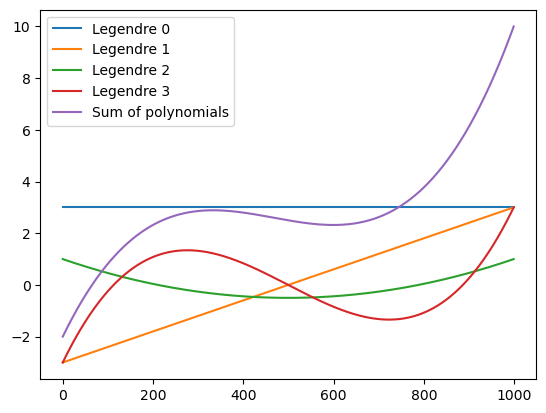

In [57]:
plt.figure()
coefs = np.zeros((4, 4))
coefs[0, 0] = 3
coefs[1, 1] = 3
coefs[2, 2] = 1
coefs[3, 3] = 3
domain = np.linspace(-1, 1, 1000)
plt.plot(np.polynomial.legendre.Legendre(coefs[0])(domain), label='Legendre 0')
plt.plot(np.polynomial.legendre.Legendre(coefs[1])(domain), label='Legendre 1')
plt.plot(np.polynomial.legendre.Legendre(coefs[2])(domain), label='Legendre 2')
plt.plot(np.polynomial.legendre.Legendre(coefs[3])(domain), label='Legendre 3')
plt.plot(np.polynomial.legendre.Legendre(np.sum(coefs, axis=1))(domain), label='Sum of polynomials')
plt.legend()